# Programmentwurf - Maschinelles Lernen

Jupyter-Notebook für den Datensatz "Cycling Data - A - bike_rides_001.csv" in Rahmen des Moduls "Computational Intelligence und Maschinelles Lernen" von Ruslan Adilgereev und Valentin Langenbacher

## Load data

Import Pandas: Required for data manipulation.
Specify CSV File Path: Initialize the file path for the dataset.
Load Data: Read the dataset into a Pandas DataFrame using a semicolon as the delimiter.

In [1]:
# Import Pandas for data handling
import pandas as pd

# Specify the CSV file path for the training data
training_data_path = "bike_rides_001.csv"

# Load the training data into a DataFrame
df = pd.read_csv(training_data_path, sep=";")
df.head()


,Hm,km,maxHm,max_speed,minHm,position_lat_max,position_lat_min,position_long_max,position_long_min,speed,type,date,endtime,starttime,rider_weight,rider_height,ride_type
0,"134,8","4,9589","283,4","30,9024",210,"48,7172702","48,71312225","9,517255425","9,49041741","13,87198442",MTB,22.04.2020,19:03:16,18:27:16,74,183,Training
1,"329,2","11,10381","534,4","40,0752","341,4","48,74377688","48,71396681","9,517455334","9,489272526","16,8602461",MTB,14.04.2020,12:47:41,11:57:47,74,183,Training
2,"388,2","16,05416","455,4","41,1804","267,2","48,74683385","48,71394443","9,517420549","9,480477059","17,17575366",MTB,04.05.2020,13:52:01,12:48:28,74,183,Training
3,"450,2","22,26266","468,6","39,906",235,"48,77745939","48,71389473","9,531488987","9,480472617","17,40292613",MTB,06.01.2020,15:27:04,14:03:59,76,183,Training
4,"202,4","14,16321","373,2","29,8944","283,2","48,7171656","48,70317033","9,536965219","9,477965757","12,46223032",MTB,31.12.2018,15:50:35,14:25:41,76,183,Training


## Data preprocessing

- Data Cleaning: Unnecessary rows and irrelevant features are removed to simplify the dataset.
- Time Feature Engineering: Time-related features are converted and simplified to create a new feature that represents the ride duration.
- Data Type Standardization: Numeric data are standardized to a common format.
- Categorical Variable Transformation: Categorical variables are transformed into a format that can be provided to machine learning algorithms.

In [2]:
# Initial Data Preprocessing

# Remove the last row, as it contains header information
df = df.drop(df.index[len(df) - 1])

# Select relevant features for the analysis
# 'Hm', 'km', 'maxHm', 'max_speed', 'minHm', 'speed', 'type', 'ride_type', 'endtime', 'starttime'
# are selected based on their potential relevance for the model.
df = df[['Hm', 'km', 'maxHm', 'max_speed', 'minHm', 'speed', 'type', 'ride_type', 'endtime', 'starttime']]

# Convert 'starttime' and 'endtime' to datetime format for easier manipulation
df['starttime'] = pd.to_datetime(df['starttime'], format='%H:%M:%S')
df['endtime'] = pd.to_datetime(df['endtime'], format='%H:%M:%S')

# Calculate the ride duration in minutes and add it as a new column
df['duration_min'] = (df['endtime'] - df['starttime']).dt.total_seconds() / 60.0

# Drop the original 'starttime' and 'endtime' columns
df = df.drop(['starttime', 'endtime'], axis=1)

# Columns that need to be converted to float type
columns_to_convert = ['Hm', 'km', 'maxHm', 'max_speed', 'minHm', 'speed']

# Convert selected columns to float type
for col in columns_to_convert:
    df[col] = df[col].str.replace(',', '.').astype('float64')


## Scaling / Normalization
Data Normalization and Standardization: Feature scaling is essential in machine learning models that calculate distances or gradients to optimize performance and ensure that each feature contributes equally to the outcome. Two common methods are used:

Min-Max Scaling: Transforms features by scaling them to a fixed range, usually [0, 1]. It is useful when the parameters have to be transformed into a bounded interval.

Z-Normalization (or Standardization): Transforms features to have a mean of 0 and a standard deviation of 1, which can be crucial for algorithms that assume features are centered around zero.

The Dataframe has a lot of extreme values, so the Min-Max Scaling is not the best choice. The Z-Normalization is a better choice for this dataset.

In [3]:
# Importing the scaling functions from scikit-learn
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Data Scaling

# Define the columns that will be scaled
columns_features = ['Hm', 'km', 'maxHm', 'max_speed', 'minHm', 'speed', 'duration_min']

# Initialize the MinMaxScaler and StandardScaler
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Apply Min-Max scaling to normalize the features within the range [0, 1]
df_minmax = pd.DataFrame(min_max_scaler.fit_transform(df[columns_features]), columns=columns_features)

# Apply Z-Normalization to standardize the features with mean=0 and variance=1
df_znorm = pd.DataFrame(standard_scaler.fit_transform(df[columns_features]), columns=columns_features)

Feature Engineering: After scaling the numerical features, the following step focuses on incorporating the transformed categorical variables back into the main dataset. One-hot encoded columns are extracted and then concatenated to the DataFrame to ensure that it is ready for model training.

In [4]:
# Perform One Hot Encoding for categorical variables 'type' and 'ride_type'
# type (MTB, Trecking, Rennrad)
# ride_type (Pendeln, Rennen, Training)
df = pd.get_dummies(df, columns=['type', 'ride_type'])

# Extract only the one-hot encoded columns from df_onehot
df_onehot_only = df.drop(columns=columns_features)

# Concatenate the one-hot encoded columns with the Min-Max scaled DataFrame
df = pd.concat([df_znorm, df_onehot_only.reset_index(drop=True)], axis=1)


Data Review: A quick review of the dataset is performed to ensure that it only contains the necessary, preprocessed features. This is an important step for a final sanity check before moving to model training.

In [5]:
# Display the first five rows of the DataFrame
# At this point, the DataFrame only contains the selected and scaled features
df.head()

,Hm,km,maxHm,max_speed,minHm,speed,duration_min,type_MTB,type_Rennrad,type_Trecking,ride_type_Pendeln,ride_type_Race,ride_type_Training
0,-0.602776,-1.186165,-0.600135,-1.726417,-0.403375,-2.786007,-0.817606,True,False,False,False,False,True
1,-0.284575,-0.987734,0.184448,-0.665260,0.552612,-1.922722,-0.681582,True,False,False,False,False,True
2,-0.188001,-0.827878,-0.062492,-0.537405,0.012778,-1.831575,-0.548004,True,False,False,False,False,True
3,-0.086517,-0.627393,-0.021231,-0.684834,-0.221490,-1.765947,-0.356852,True,False,False,False,False,True
4,-0.492125,-0.888940,-0.319436,-1.843028,0.129184,-3.193274,-0.339075,True,False,False,False,False,True


Correlation Analysis: Understanding the relationships between variables is key for feature selection and model interpretation. A correlation matrix is computed and visualized as a heatmap to inspect how each feature correlates with the target variable and other features.

Hm                    1.000000
km                    0.885016
duration_min          0.867896
max_speed             0.598599
maxHm                 0.597764
ride_type_Race        0.566555
type_Rennrad          0.403515
speed                 0.289848
ride_type_Training    0.274937
minHm                 0.228424
type_MTB             -0.090946
type_Trecking        -0.364922
ride_type_Pendeln    -0.373034
Name: Hm, dtype: float64


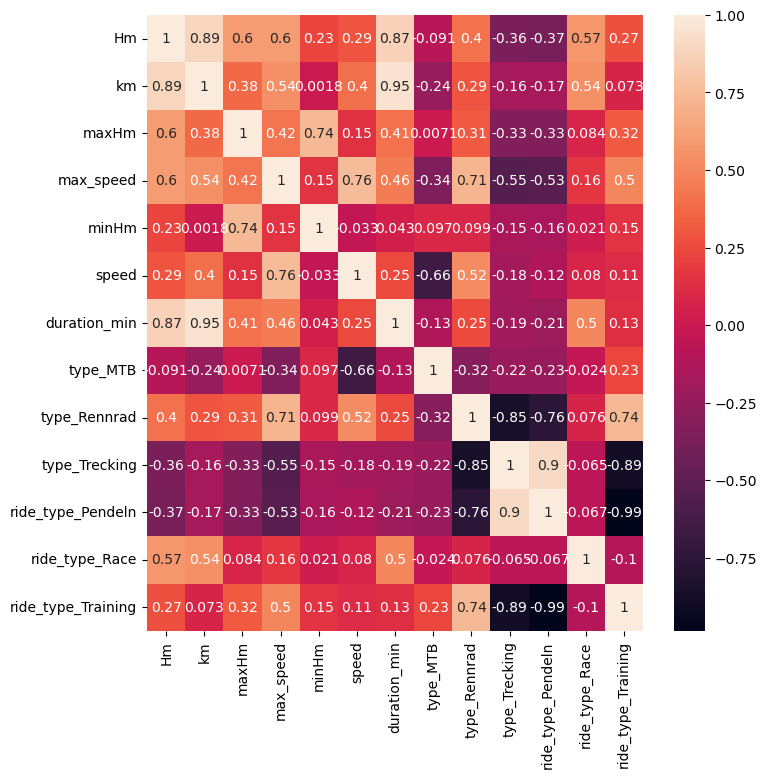

In [6]:
# Import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Data Correlation Analysis

# Calculate the correlation matrix for the DataFrame
corr = df.corr()

# Display correlation values with the target variable 'Hm' sorted in descending order
print(df.corr()['Hm'].sort_values(ascending=False))

# Generate a heatmap to visualize the correlation matrix
plt.figure(figsize=(8, 8))
sns.heatmap(corr, annot=True)
plt.show()

In the following step, removing attributes contributes to a reduction in dimensionality, leading to a more straightforward and computationally efficient model, particularly beneficial for extensive datasets. Additionally, it plays a crucial role in preventing overfitting and enhancing the interpretability of the model, as fewer attributes result in a model that is simpler to comprehend and analyze.

In [7]:
# Choosing important features from the correlation matrix
important_features = ['km', 'duration_min', 'max_speed', 'maxHm', 'ride_type_Race', 'type_Rennrad']
df = df[['Hm'] + important_features]

Data Splitting for Model Training 
- This step is crucial for training and validating machine learning models. The dataset is divided into features (X) and the target variable (y). The train_test_split function is then used to split the data into training and validation sets. An 80/20 split ratio is commonly used for a good balance between training and validation.

In [8]:
# Importing the train_test_split function for data splitting
from sklearn.model_selection import train_test_split

# Define features (X) and target variable (y)
X = df.drop('Hm', axis=1)
y = df['Hm']
# Split the data into 80% training and 20% validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## MLP vs Linear Regression

Model Training and Evaluation: Two types of regression models, Linear Regression and MLP (MLP Regressor), are trained on the dataset. Various performance metrics like MAE (Mean Absolute Error), MSE (Mean Squared Error), RMSE (Root Mean Squared Error), and R² score are calculated to evaluate and compare their performance.

In [9]:
# Importing relevant libraries for model training and evaluation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
import numpy as np

# Model Initialization and Training

# Initialize the MLP Regressor and Linear Regression models
mlp = MLPRegressor(hidden_layer_sizes=(200, 5, 3), max_iter=1000, activation="relu", random_state=42)
lin = LinearRegression()

# Train both models using the training data
mlp.fit(X_train, y_train)
lin.fit(X_train, y_train)

# Make predictions using both models on the validation set
mlp_y_pred = mlp.predict(X_val)
lin_y_pred = lin.predict(X_val)

# Calculate performance metrics for both models
metrics = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'R2'],
    'Linear Regression': [
        mean_absolute_error(y_val, lin_y_pred),
        mean_squared_error(y_val, lin_y_pred),
        np.sqrt(mean_squared_error(y_val, lin_y_pred)),
        r2_score(y_val, lin_y_pred)
    ],
    'MLP': [
        mean_absolute_error(y_val, mlp_y_pred),
        mean_squared_error(y_val, mlp_y_pred),
        np.sqrt(mean_squared_error(y_val, mlp_y_pred)),
        r2_score(y_val, mlp_y_pred)
    ]
}

# Display the metrics in a DataFrame for easier comparison
df_metrics = pd.DataFrame(metrics)
print(df_metrics)


  Metric  Linear Regression       MLP
0    MAE           0.185159  0.116035
1    MSE           0.084675  0.027695
2   RMSE           0.290989  0.166419
3     R2           0.790884  0.931603


Comparison of various configurations:
- Hidden Layers: Start with a simple network and gradually add complexity based on training performance and generalization.
- The number of neurons in the hidden layers can fall between the size of the input and output layers. A common practice is to start with a number that corresponds to the average of the neurons in the input and output layers.
- Optimal Configuration (after experiments):
Layer 1: 200 neurons; Layer 2: 5 neurons; Layer 3: 3 neurons

Result: This configuration demonstrated the best metric results during iterative experimentation.

Comparison MLP/LinReg & Evaluation:

- Mean Absolute Error:
The MLP has a lower MAE of 0.116035 compared to the Linear Regression's 0.185159, indicating better prediction accuracy.

- Mean Squared Error:
With an MSE of 0.027695, the MLP outperforms the Linear Regression model, which has an MSE of 0.084675.

- Root Mean Squared Error:
The MLP's RMSE of 0.166419 is lower than the Linear Regression's 0.290989, signifying more accurate predictions.

- R-Squared:
The MLP's R^2 value of 0.931603 is higher than the Linear Regression's 0.790884, indicating a better fit to the data.

In summary, based on these metrics, the MLP demonstrates superior performance over Linear Regression for this dataset.

Model Prediction Visualization: To provide a qualitative assessment of the model's performance, the predicted outcomes from the MLP and Linear Regression models are plotted against the actual values. Two subplots are used for clear comparison.

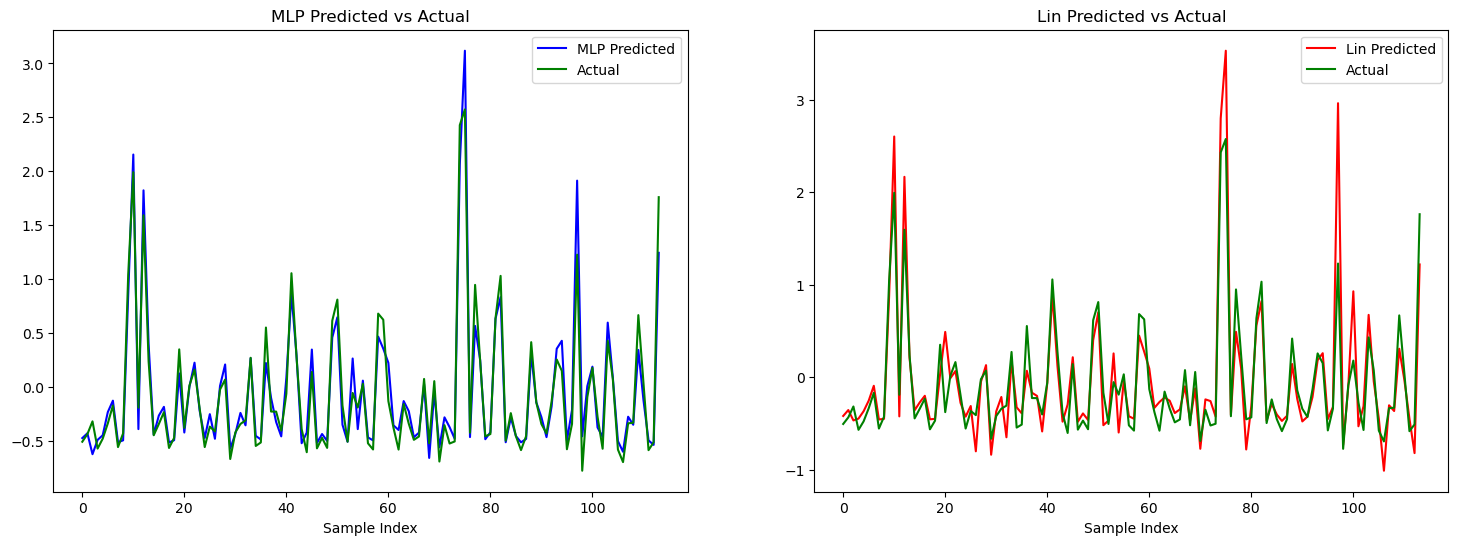

In [10]:
# Visualization: Comparison of Model Predictions

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# First subplot for MLP predictions
axes[0].plot(mlp_y_pred, label='MLP Predicted', color='b')
axes[0].plot(y_val.values, label='Actual', color='g')
axes[0].set_title('MLP Predicted vs Actual')
axes[0].set_xlabel('Sample Index')
axes[0].legend()

# Second subplot for Linear Regression predictions
axes[1].plot(lin_y_pred, label='Lin Predicted', color='r')
axes[1].plot(y_val.values, label='Actual', color='g')
axes[1].set_title('Lin Predicted vs Actual')
axes[1].set_xlabel('Sample Index')
axes[1].legend()

# Display the plot
plt.show()


Error Visualization: This step aims to visually analyze the errors in the predictions made by the MLP and Linear Regression models. The errors are plotted across the sample index to provide insights into the reliability and stability of the models.

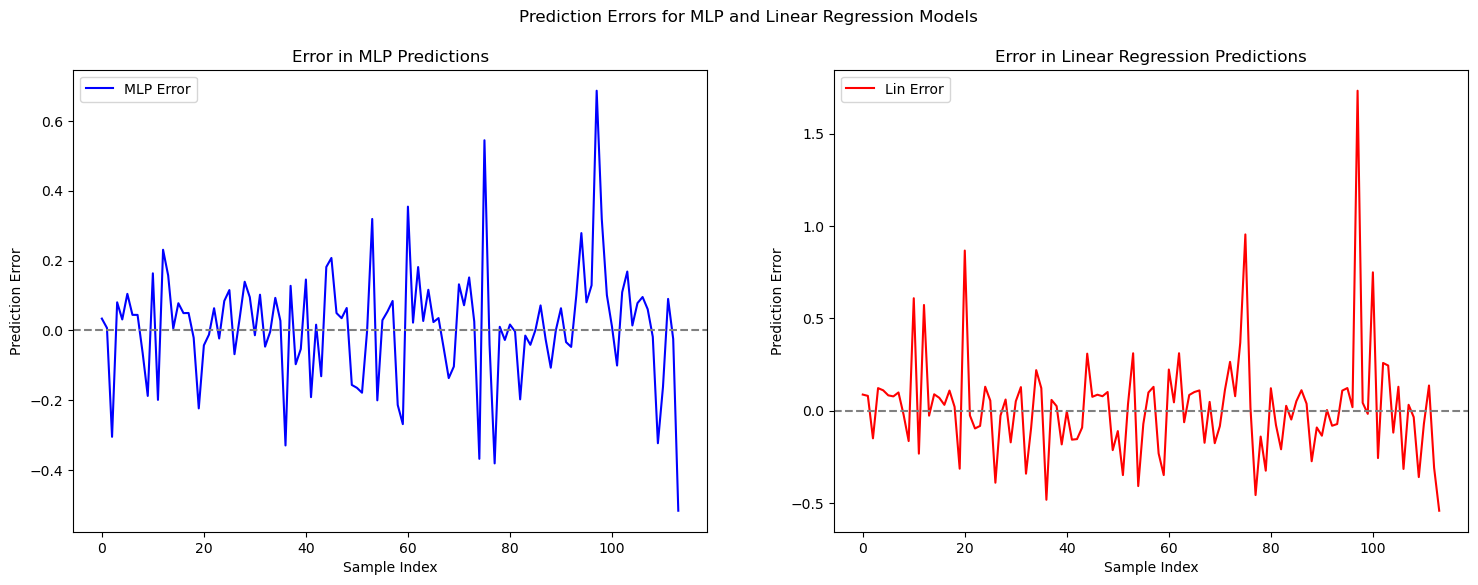

In [11]:
# Visualization: Model Prediction Errors

# Calculate the prediction errors for both MLP and Linear Regression
mlp_error = mlp_y_pred - y_val.values
lin_error = lin_y_pred - y_val.values

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# First subplot for MLP prediction errors
axes[0].plot(mlp_error, label='MLP Error', color='b')
axes[0].axhline(0, color='gray', linestyle='--')  # Add horizontal line at y=0
axes[0].set_title('Error in MLP Predictions')
axes[0].set_xlabel('Sample Index')
axes[0].set_ylabel('Prediction Error')
axes[0].legend()

# Second subplot for Linear Regression prediction errors
axes[1].plot(lin_error, label='Lin Error', color='r')
axes[1].axhline(0, color='gray', linestyle='--')  # Add horizontal line at y=0
axes[1].set_title('Error in Linear Regression Predictions')
axes[1].set_xlabel('Sample Index')
axes[1].set_ylabel('Prediction Error')
axes[1].legend()

# Add overall title and display the plot
fig.suptitle('Prediction Errors for MLP and Linear Regression Models')
plt.show()


In summary, the charts depict how accurate or inaccurate each model is in predicting across various samples. The MLP model seems to generally have smaller errors, whereas the linear regression model exhibits some significant deviations, especially for certain specific samples.

Residual Analysis: Histograms of residuals (the differences between the predicted and actual values) for both MLP and Linear Regression models are plotted. This visualization helps in understanding the distribution of errors and in identifying any systematic issues in the models.

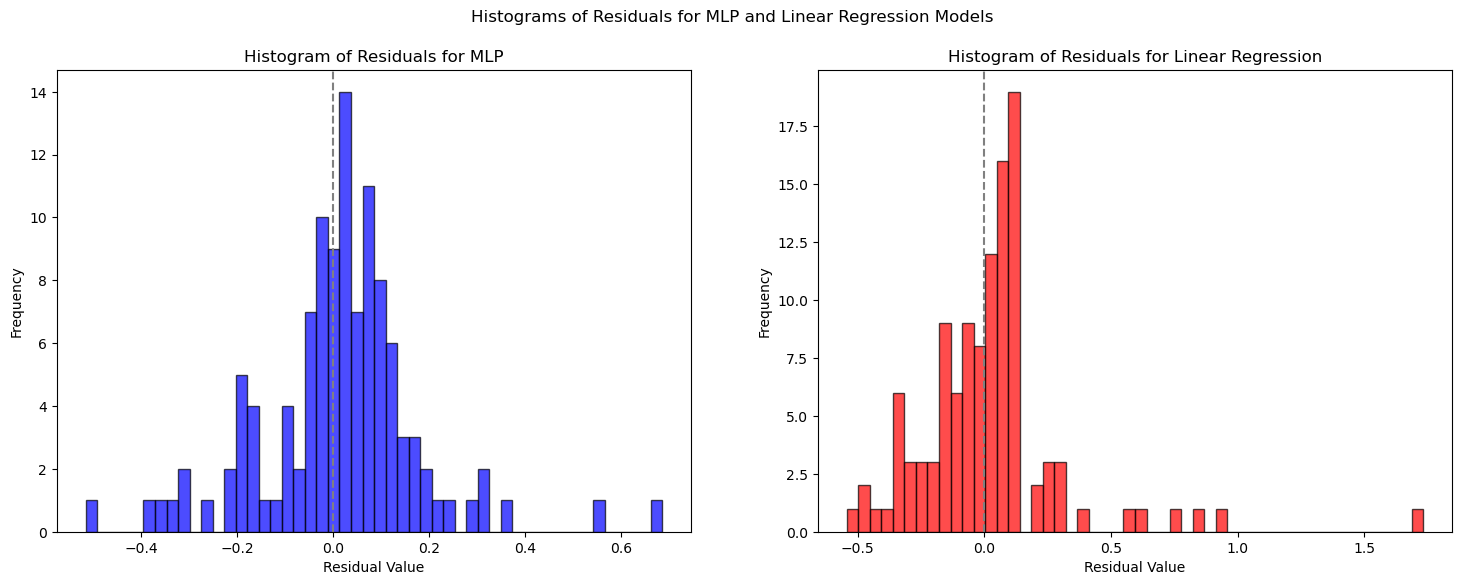

In [12]:
# Visualization: Histogram of Model Residuals

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# First subplot for MLP residuals
axes[0].hist(mlp_error, bins=50, edgecolor='black', color='b', alpha=0.7)
axes[0].axvline(0, color='gray', linestyle='--')  # Add vertical line at x=0
axes[0].set_title('Histogram of Residuals for MLP')
axes[0].set_xlabel('Residual Value')
axes[0].set_ylabel('Frequency')

# Second subplot for Linear Regression residuals
axes[1].hist(lin_error, bins=50, edgecolor='black', color='r', alpha=0.7)
axes[1].axvline(0, color='gray', linestyle='--')  # Add vertical line at x=0
axes[1].set_title('Histogram of Residuals for Linear Regression')
axes[1].set_xlabel('Residual Value')
axes[1].set_ylabel('Frequency')

# Add overall title and display the plot
fig.suptitle('Histograms of Residuals for MLP and Linear Regression Models')
plt.show()


The boxplot of the MLP is closer to a shape of normal distribution, therefore it fits better.

Residuals vs Fitted Values: This scatter plot visually compares the residuals (errors) against the fitted values (predictions) for both MLP and Linear Regression models. It helps in identifying any non-linearity or patterns in the residuals, which could indicate model inadequacies.

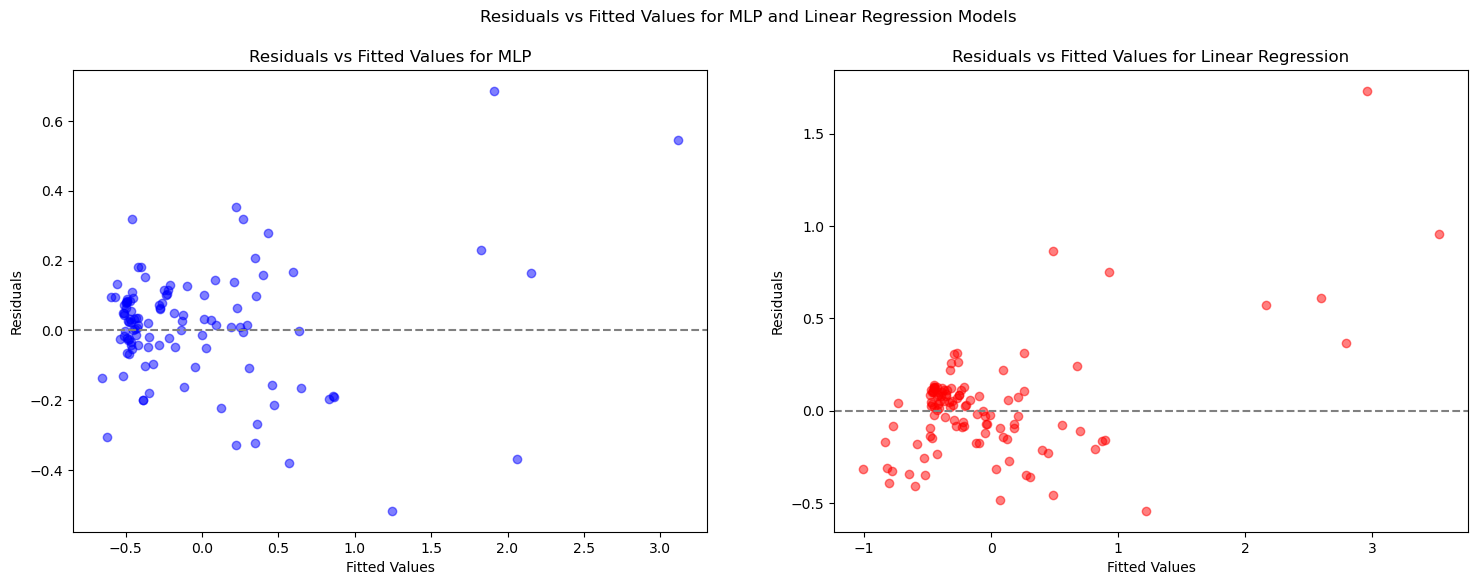

In [13]:
# Visualization: Residuals vs Fitted Values

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# First subplot for MLP residuals
axes[0].scatter(mlp_y_pred, mlp_error, color='b', alpha=0.5)
axes[0].axhline(y=0, color='gray', linestyle='--')  # Add horizontal line at y=0
axes[0].set_title('Residuals vs Fitted Values for MLP')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Residuals')

# Second subplot for Linear Regression residuals
axes[1].scatter(lin_y_pred, lin_error, color='r', alpha=0.5)
axes[1].axhline(y=0, color='gray', linestyle='--')  # Add horizontal line at y=0
axes[1].set_title('Residuals vs Fitted Values for Linear Regression')
axes[1].set_xlabel('Fitted Values')
axes[1].set_ylabel('Residuals')

# Add overall title and display the plot
fig.suptitle('Residuals vs Fitted Values for MLP and Linear Regression Models')
plt.show()


The distribution of the Residuals around zero is not significantly different in the plots, therefore it is hard to assume which model fits better.

Normal Q-Q Plots: Quantile-Quantile (Q-Q) plots are used to assess if the residuals follow a normal distribution, an important assumption in many statistical models. The Q-Q plots for both MLP and Linear Regression models are generated to compare the distribution of residuals against a standard normal distribution.

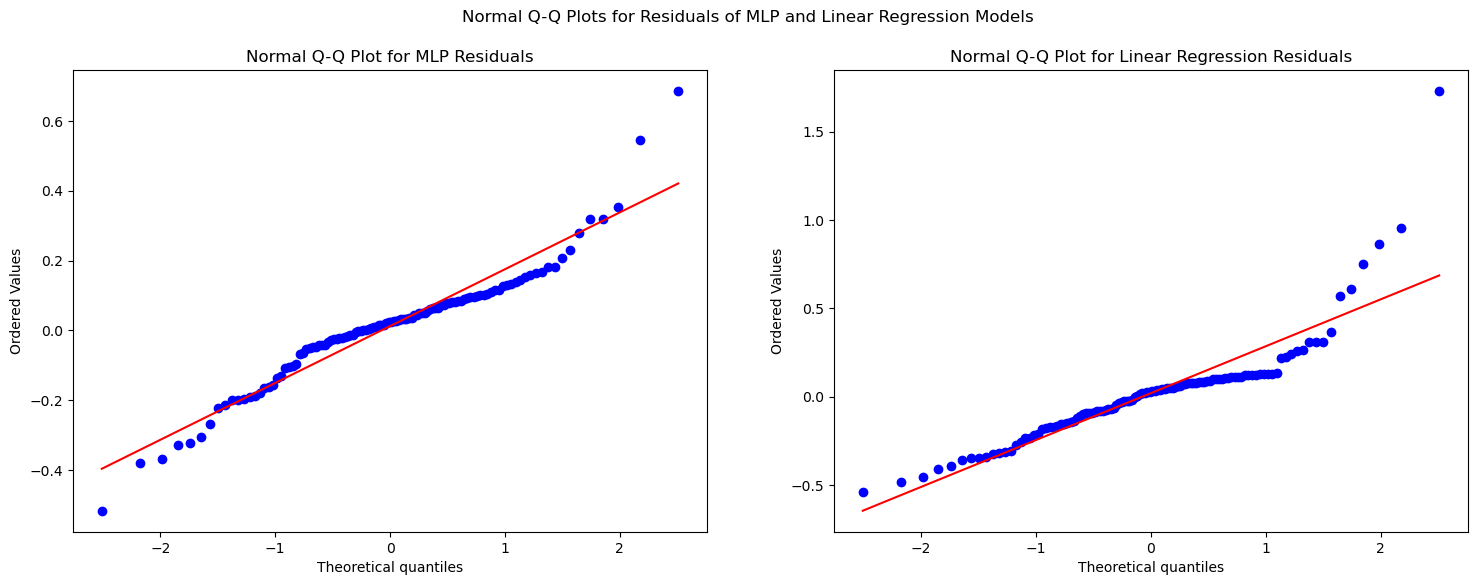

In [14]:
# Visualization: Normal Q-Q Plots for Model Residuals

# Import statistical functions from scipy
import scipy.stats as stats  

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# First subplot for MLP residuals
stats.probplot(mlp_error, dist="norm", plot=axes[0])
axes[0].set_title('Normal Q-Q Plot for MLP Residuals')

# Second subplot for Linear Regression residuals
stats.probplot(lin_error, dist="norm", plot=axes[1])
axes[1].set_title('Normal Q-Q Plot for Linear Regression Residuals')

# Add overall title and display the plot
fig.suptitle('Normal Q-Q Plots for Residuals of MLP and Linear Regression Models')
plt.show()


The Q-Q Plot visualize the distribution of the residuals against a standard normal distribution. The Q-Q plot is used to understand the distribution of the residuals. The Q-Q plot shows the residuals of the MLP and the linear regression model. The Q-Q plot shows that the residuals of the MLP are closer to the normal distribution than the residuals of the linear regression model.
The Q-Q Plot of MLP shows that the residuals are closer to the normal distribution than the Q-Q Plot of the linear regression model. In the higher quantiles the Residuals of MLP are closer to the normal distribution than the residuals of the linear regression model.

Boxplot Analysis: Boxplots are utilized to visualize the distribution of the residuals (errors) for both MLP and Linear Regression models. This type of graph is particularly useful for identifying outliers and understanding the spread and skewness of the data.

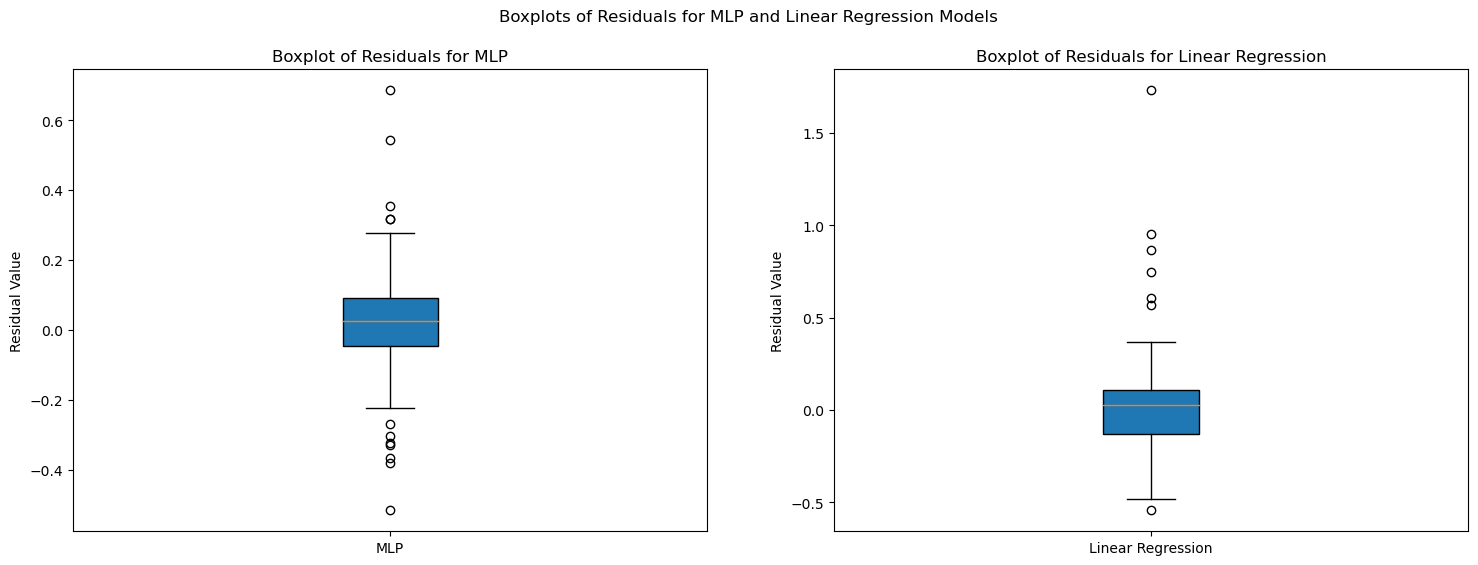

In [15]:
# Visualization: Boxplots of Model Residuals

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# First subplot for MLP residuals
axes[0].boxplot(mlp_error, vert=True, patch_artist=True, labels=['MLP'])
axes[0].set_title('Boxplot of Residuals for MLP')
axes[0].set_ylabel('Residual Value')

# Second subplot for Linear Regression residuals
axes[1].boxplot(lin_error, vert=True, patch_artist=True, labels=['Linear Regression'])
axes[1].set_title('Boxplot of Residuals for Linear Regression')
axes[1].set_ylabel('Residual Value')

# Add overall title and display the plot
fig.suptitle('Boxplots of Residuals for MLP and Linear Regression Models')
plt.show()


Boxplot:
Boxplots are used to visualize the distribution of residuals (errors) for both MLP and Linear Regression models. This type of graph is particularly useful for identifying outliers and understanding the spread and skewness of the data. The boxplot is a good way to visualize the distribution of the residuals. The boxplot shows the median, the interquartile range, and the outliers of the residuals. In this example the MLP has a better distribution of the residuals than the linear regression model, because the median is closer to zero and the interquartile range is smaller.

Loss Curve Analysis: The loss curve represents the model's performance metric (in this case, the cost or loss) across different iterations during the training phase. This curve aids in understanding the model's convergence behavior.

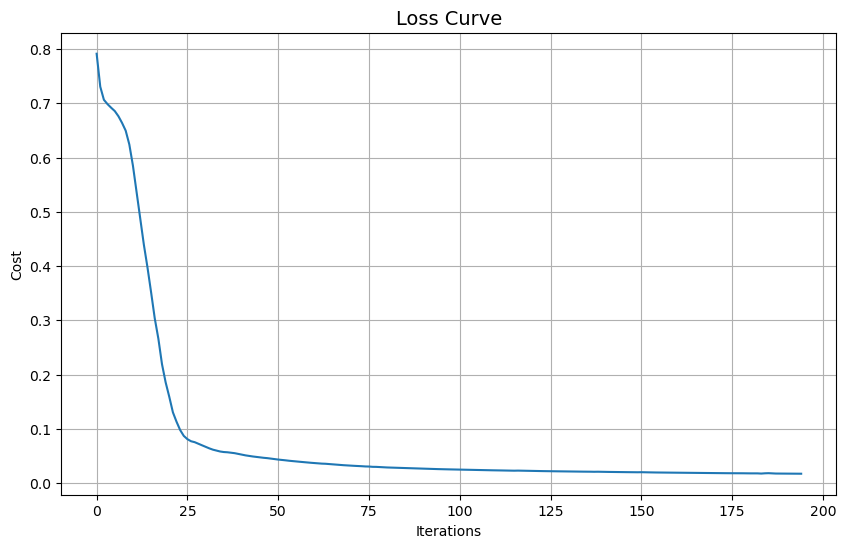

In [16]:
# Visualization: Loss Curve for MLP

# Obtain loss curve data from the model
mlp_loss_curve = mlp.loss_curve_

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(mlp_loss_curve)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.grid(True)  # Add grid for better

Loss Curve:
The Loss Curve shows the loss of the model over the training iterations. The loss is calculated as the difference between the predicted and actual values. The loss curve is used to understand the model's convergence behavior.

Linear Regression Scatter Plot and Fitted Line: This visualization presents the actual data points alongside the line fitted by the Linear Regression model. The "Fitted Line" represents the model's predictions across the range of km values in the validation set.

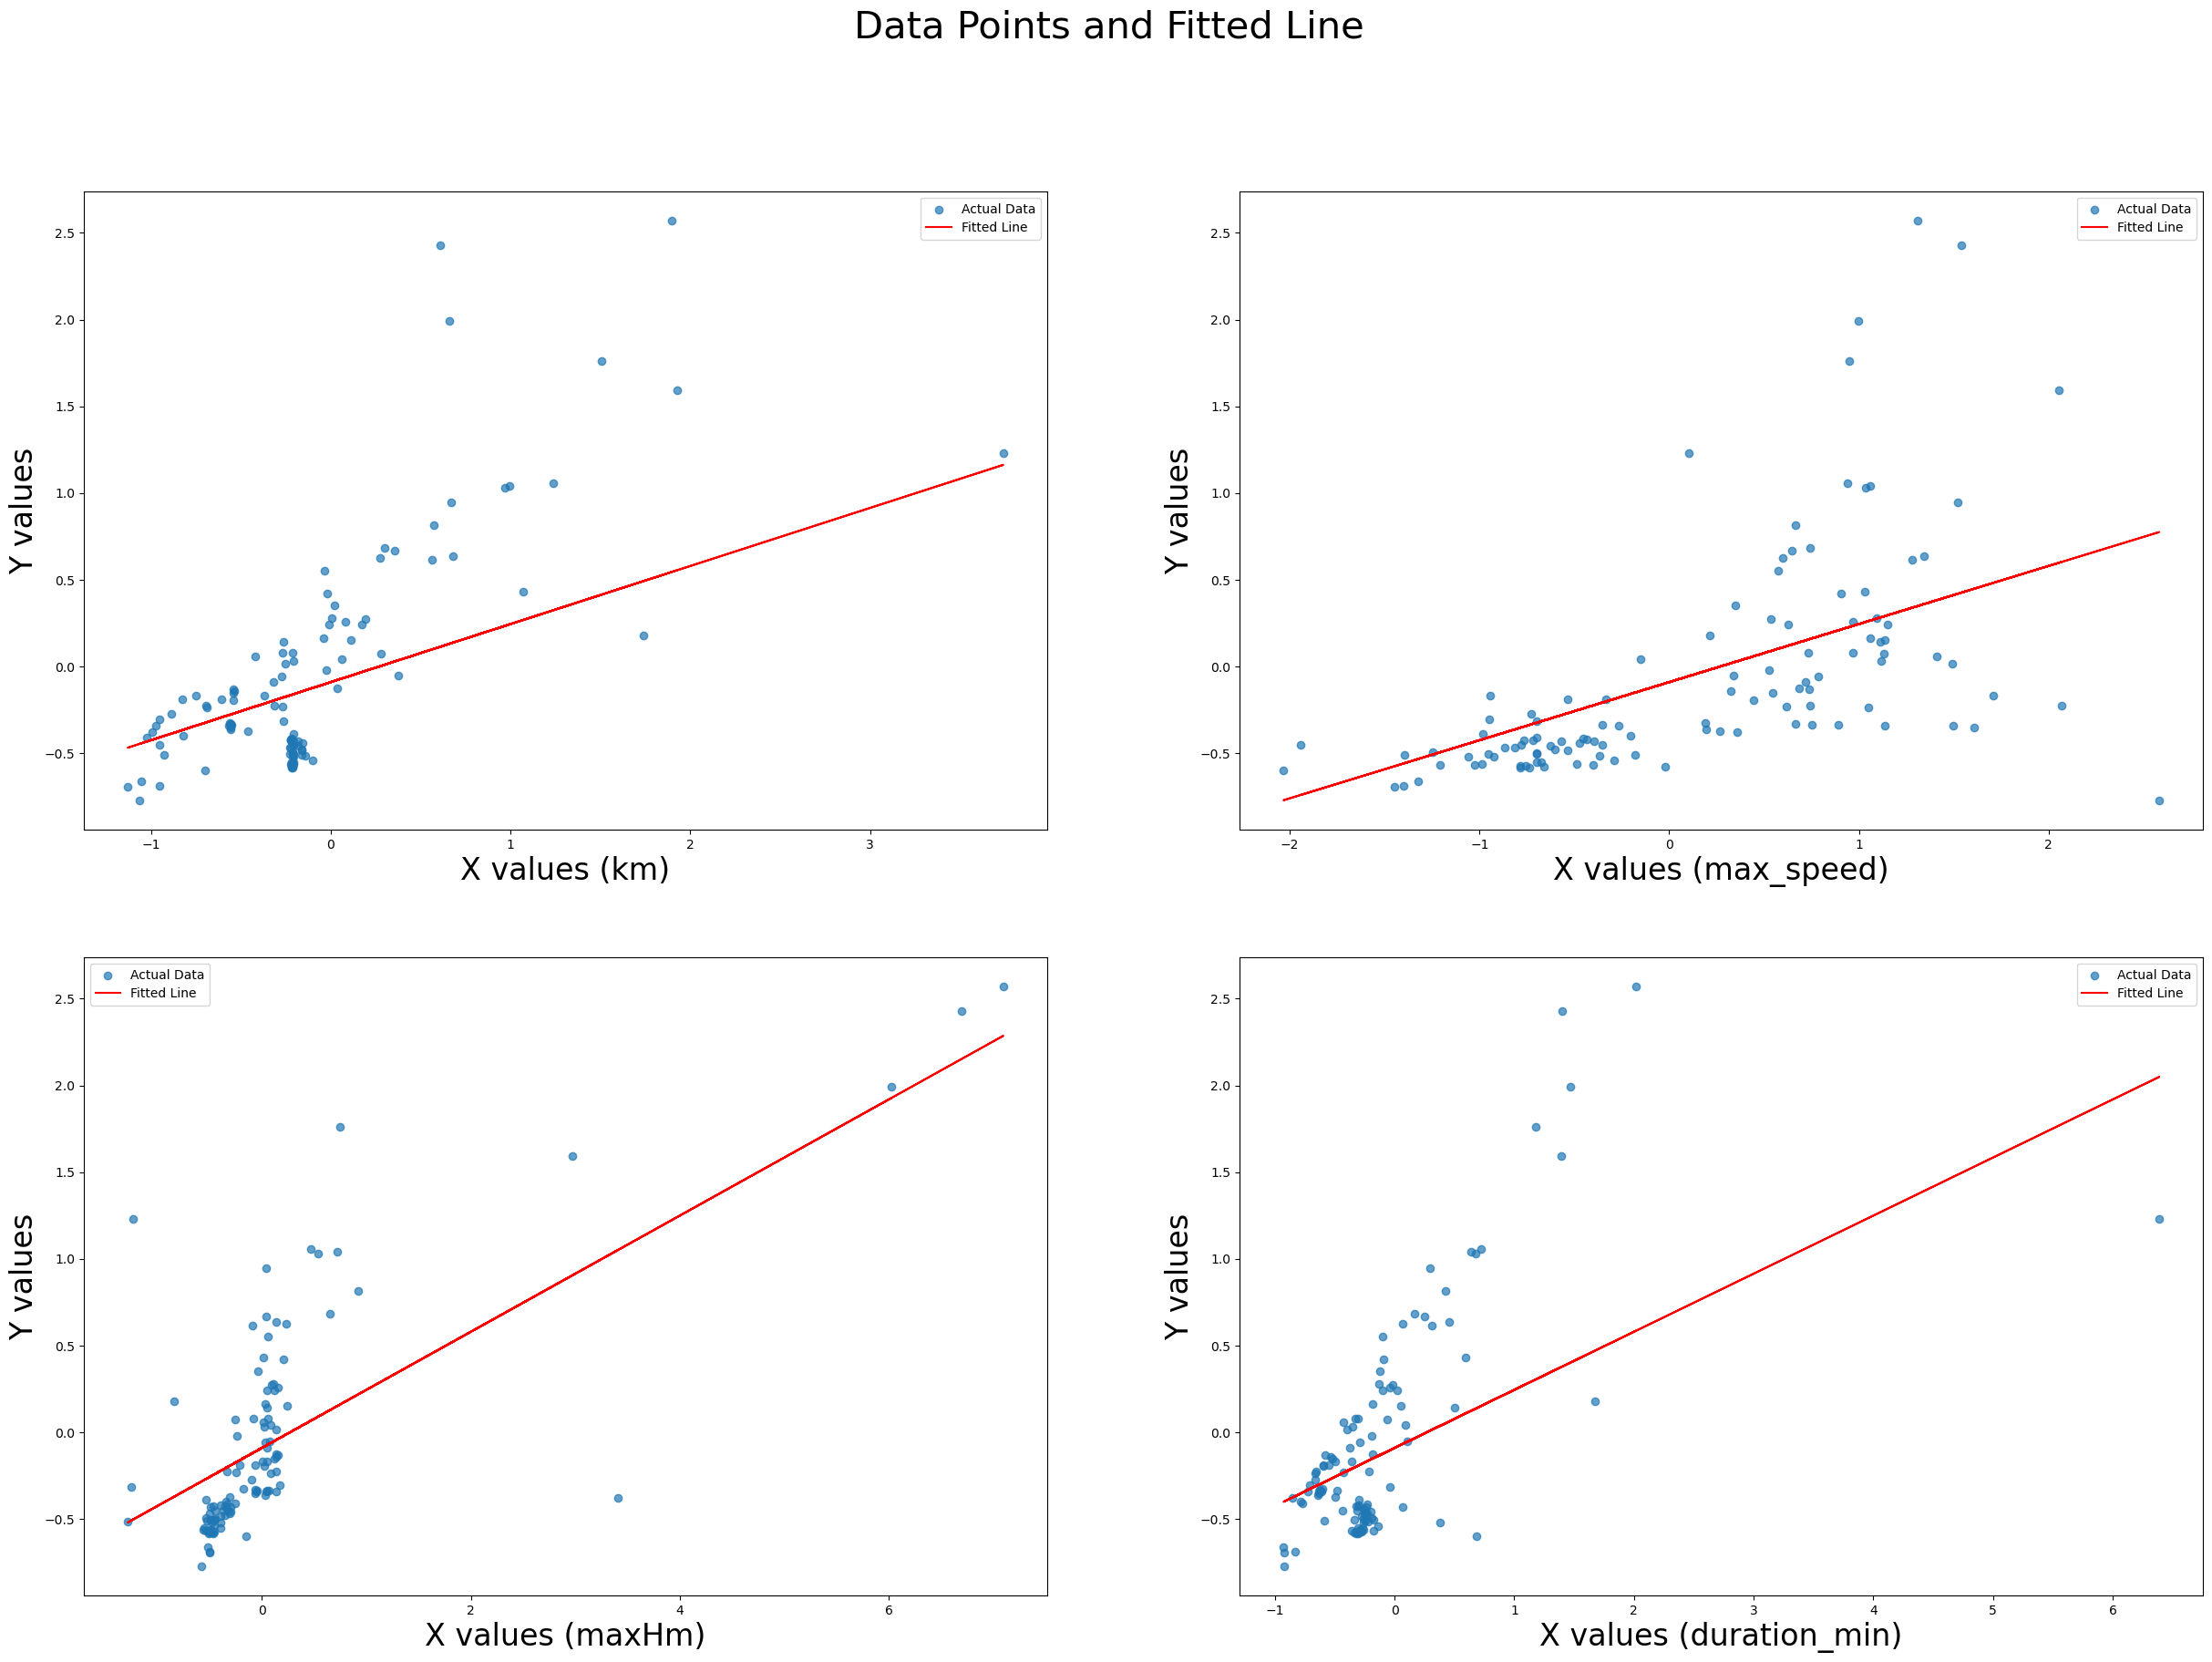

In [17]:
# Visualization: Scatter Plot and Fitted Line for Linear Regression Model

# Obtain the slope (m) and intercept (b) from the trained linear model
m = lin.coef_[0]
b = lin.intercept_

# Calculate the y-values based on the line equation y = mx + b
y_line_km = m * X_val["km"] + b

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 20))

# Create the scatter plot for actual data and the line for fitted values
axes[0,0].scatter(X_val["km"], y_val, label='Actual Data', alpha=0.7)
axes[0,0].plot(X_val["km"], y_line_km, label='Fitted Line', color='red')

# Add labels and title
axes[0,0].set_xlabel('X values (km)', fontsize=24)
axes[0,0].set_ylabel('Y values', fontsize=24)
axes[0,0].legend()

y_line_maxHm = m * X_val["maxHm"] + b

# Create the scatter plot for actual data and the line for fitted values
axes[1,0].scatter(X_val["maxHm"], y_val, label='Actual Data', alpha=0.7)
axes[1,0].plot(X_val["maxHm"], y_line_maxHm, label='Fitted Line', color='red')

# Add labels and title
axes[1,0].set_xlabel('X values (maxHm)', fontsize=24)
axes[1,0].set_ylabel('Y values', fontsize=24)
axes[1,0].legend()

y_line_max_speed = m * X_val["max_speed"] + b

# Create the scatter plot for actual data and the line for fitted values
axes[0,1].scatter(X_val["max_speed"], y_val, label='Actual Data', alpha=0.7)
axes[0,1].plot(X_val["max_speed"], y_line_max_speed, label='Fitted Line', color='red')

# Add labels and title
axes[0,1].set_xlabel('X values (max_speed)', fontsize=24)
axes[0,1].set_ylabel('Y values', fontsize=24)
axes[0,1].legend()

y_line_duration_min = m * X_val["duration_min"] + b

# Create the scatter plot for actual data and the line for fitted values
axes[1,1].scatter(X_val["duration_min"], y_val, label='Actual Data', alpha=0.7)
axes[1,1].plot(X_val["duration_min"], y_line_duration_min, label='Fitted Line', color='red')

# Add labels and title
axes[1,1].set_xlabel('X values (duration_min)', fontsize=24)
axes[1,1].set_ylabel('Y values', fontsize=24)
axes[1,1].legend()
fig.suptitle('Data Points and Fitted Line', fontsize=30)
plt.show()

Plot of linear Regression Model: This visualization presents the actual data points alongside the line fitted by the Linear Regression model. The "Fitted Line" represents the model's predictions across the range of different feature values in the validation set.
Due to multiple features, the plot is not quite useful.